In [19]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
from PIL import Image, ImageDraw, ImageFont
import os
from copy import deepcopy
from transformers import CLIPTextModel, CLIPTokenizer

model_id = "stabilityai/stable-diffusion-2-base"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [2]:
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
    use_auth_token=True,
)
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder", use_auth_token=True
)

vocab_size = tokenizer.vocab_size

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [3]:
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds

  print(trained_token)


In [4]:
embed_paths = [
    "ugly_sonic_sd_2_0.bin",
    "wrong_sd_2_0.bin",
    "midjourney_sd_2_0.bin"
    ]

for embed in embed_paths:
    load_learned_embed_in_clip(embed, text_encoder, tokenizer)

<ugly-sonic>
<wrong>
<midjourney>


In [5]:
# Use the Euler scheduler here instead
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               scheduler=scheduler,
                                               text_encoder=text_encoder,
                                               tokenizer=tokenizer,
                                               revision="fp16",
                                               torch_dtype=torch.float16,
                                               safety_checker=None)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
def latents_generator(seed=0):
    g = torch.Generator(device='cuda')
    g.manual_seed(seed)

    latent_shape = (pipe.unet.in_channels,
                    512 // pipe.vae_scale_factor,
                    512 // pipe.vae_scale_factor)
    latent = torch.randn(latent_shape, generator=g, device="cuda")
    latent_batched = torch.repeat_interleave(latent.unsqueeze(0), 3, dim=0).to('cuda')
    return g, latent_batched


In [7]:
font = ImageFont.truetype('SourceCodePro-ExtraBold.ttf', size=70)

def label_generator(label_text, text_color, bg_color):
    # Render at 2x then downsample for text AA
    image = Image.new('RGB', (400, 100), bg_color)
    image_editable = ImageDraw.Draw(image)
    image_editable.text((10,5), label_text.upper(), text_color, font=font, align="left")
    image = image.resize((image.width // 2, image.height // 2))
    return image

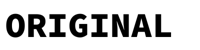

In [8]:
label_dict = {
    "original": label_generator("original", (0,0,0), (255,255,255)),
    "pos_prompt": label_generator("prompt", (255,255,255), (39,174,96)),
    "pos_token": label_generator("<token>", (255,255,255), (39,174,96)),
    "neg_prompt": label_generator("prompt", (255,255,255), (192,57,43)),
    "neg_token": label_generator("<token>", (255,255,255), (192,57,43)),

}
label_dict["original"]

In [9]:
def prompt_builder(keys):
    return_dict = {"prompt": prompt_dict["original"],
                   "negative_prompt": ""}
    for key in keys:
        if key == "original":
            break
        else:
            if "pos" in key:
                return_dict["prompt"] += f", {prompt_dict[key]}"
            elif "neg" in key:
                return_dict["negative_prompt"] = prompt_dict[key]
    return return_dict
            

In [10]:
# probably don't have to hardcode it, but it's easier and ensures correct label order.
grid_order=[
    ["original"],
    ["pos_prompt"],
    ["pos_token"],
    ["neg_prompt"],
    ["pos_prompt", "neg_prompt"],
    ["pos_token", "neg_prompt"],
    ["neg_token"],
    ["pos_prompt", "neg_token"],
    ["pos_token", "neg_token"]
]

In [84]:
seed = [3**8, 3**9, 3**10, 3**11, 3**12]
base_prompt = "Steve Jobs head"
pos_prompt = "hyper-detailed and intricate, realistic shaded, fine detail, realistic proportions, symmetrical, sharp focus, 8K resolution"
pos_token = "in the style of <midjourney>"
neg_prompt = "ugly, boring, bad anatomy"
neg_token = "in the style of <wrong>"

In [ ]:
prompt_dict = {
    "original": base_prompt,
    "pos_prompt": pos_prompt,
    "pos_token": pos_token,
    "neg_prompt": neg_prompt,
    "neg_token": neg_token,

}

if isinstance(seed, int):
    seed = [seed]
    
if not os.path.exists("individual_outputs"):
    os.mkdir("individual_outputs")

for rng_seed in seed:
    print(f"Seed used: {rng_seed}")
    
    raw_outputs = []
    all_images = []
    
    g, latent_batched = latents_generator(rng_seed)
    for row in range(3):
        key_lists = grid_order[(row * 3) : (row * 3 + 3)]
        prompt_dicts = [prompt_builder(x) for x in key_lists]
        prompts = [x["prompt"] for x in prompt_dicts]
        negative_prompts = [x["negative_prompt"] for x in prompt_dicts]
        with torch.autocast("cuda"):
            g.manual_seed(rng_seed)  # reset seed before generation for deterministic sampling
            images = pipe(prompt=prompts,
                          negative_prompt=negative_prompts,
                          latents=latent_batched,
                          generator=g,
                          num_inference_steps=50, guidance_scale=7.5)["images"]
            
            # collect the unlabeled images for individual saving
            raw_outputs.extend(deepcopy(images))

            # paste label images onto each generated image
            for i in range(len(images)):
                labels = [label_dict[x] for x in key_lists[i]]
                label_vstack = image_grid(labels, len(labels), 1)
                images[i].paste(label_vstack)

            all_images.extend(images)
            image_large = image_grid(images, 1, 3)
            display(image_large.resize((image_large.width // 2, image_large.height // 2)))

    grid = image_grid(all_images, 3, 3)
    grid.save(f"promptgrid_seed_{rng_seed}.png")
    
    for i, image in enumerate(raw_outputs):
        image.save(os.path.join("individual_outputs", f"seed_{rng_seed}_{i+1:02d}.png"))